In [1]:
#Kullanacağımız fonksiyonları içerisinde bulunduran kütüphaneleri import ediyoruz.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from csv import reader

In [2]:
#verilerimizi okuyoruz.
with open("DataSetA.csv", 'r') as f:
    csv = reader(f)
    data = list(csv)

data

[['Lassi', 'Coffee Powder', 'Butter', 'Yougurt', 'Ghee', 'Cheese', ''],
 ['Ghee', 'Coffee Powder', ''],
 ['Lassi', 'Tea Powder', 'Butter', 'Cheese', ''],
 ['Cheese', 'Tea Powder', 'Panner', 'Coffee Powder', 'Butter', 'Bread', ''],
 ['Cheese', 'Yougurt', 'Coffee Powder', 'Sugar', 'Butter', 'Sweet', ''],
 ['Sugar', 'Tea Powder', 'Ghee', 'Sweet', 'Panner', 'Milk', ''],
 ['Sweet', 'Coffee Powder', ''],
 ['Butter', 'Ghee', 'Panner', ''],
 ['Sweet', 'Tea Powder', 'Butter', 'Yougurt', 'Sugar', 'Cheese', ''],
 ['Panner', 'Ghee', ''],
 ['Milk', 'Panner', 'Tea Powder', 'Sweet', 'Bread', ''],
 ['Ghee',
  'Coffee Powder',
  'Milk',
  'Yougurt',
  'Lassi',
  'Sugar',
  'Butter',
  'Panner',
  ''],
 ['Butter', 'Coffee Powder', 'Panner', 'Sweet', 'Ghee', 'Lassi', ''],
 ['Bread',
  'Lassi',
  'Coffee Powder',
  'Tea Powder',
  'Sweet',
  'Ghee',
  'Sugar',
  'Panner',
  ''],
 ['Milk', 'Sweet', 'Butter', 'Sugar', 'Lassi', 'Panner', ''],
 ['Bread', 'Coffee Powder', 'Tea Powder', ''],
 ['Butter', 'Ghee',

In [3]:
#Veri setini oluşturduktan sonra nested list (iç içe liste) tipindeki verilerimizi tabular bir yapıya çevirmemiz gerekiyor.
#Bunun için mlxtend modülü içerisinde yer alan preprocessing sınıfı içerisinde TransactionEncoder fonksiyonunu kullanacağız.
#TransactionEncoder, fit yöntemi aracılığıyla veri kümesindeki benzersiz etiketleri öğrenir ve transform yöntemi aracılığıyla,
#giriş veri kümesini (listelerden oluşan bir Python listesi) tek seferde kodlanmış bir NumPy boolean dizisine dönüştürür
te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df = pd.DataFrame(te_ary, columns=te.columns_)
df.drop('',axis=1, inplace=True)
df

,Bread,Butter,Cheese,Coffee Powder,Ghee,Lassi,Milk,Panner,Sugar,Sweet,Tea Powder,Yougurt
0,False,True,True,True,True,True,False,False,False,False,False,True
1,False,False,False,True,True,False,False,False,False,False,False,False
2,False,True,True,False,False,True,False,False,False,False,True,False
3,True,True,True,True,False,False,False,True,False,False,True,False
4,False,True,True,True,False,False,False,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
12521,True,False,True,False,False,False,True,True,True,False,False,False
12522,True,False,True,True,False,False,False,False,True,False,False,False
12523,True,False,True,False,False,False,True,False,False,False,False,True
12524,True,False,True,False,True,False,False,False,True,False,False,True


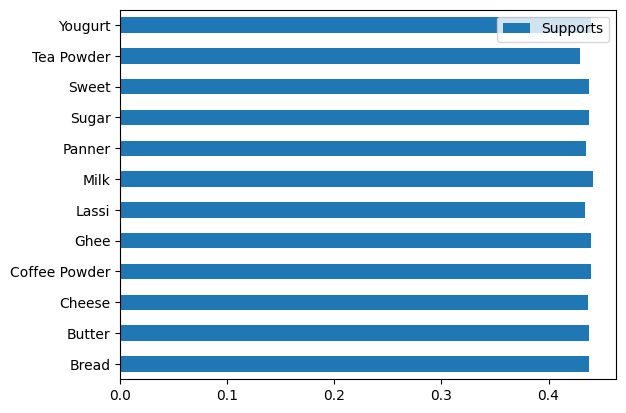

In [4]:
#Bizden istendiği gibi Tüm ürünlerimizin ayrı ayrı Support değerlerini bulduk.
supports = {} 
for col in df:
    supports[col] = df[col].value_counts()[1] / df.shape[0]
    
values =pd.DataFrame([supports])
values_T=values.T
values_T.rename(columns={"index":"Basket",0:"Supports"},inplace=True)
#values_T.plot.pie(subplots=True, figsize=(15, 15))
values_T.plot.barh(stacked=True);


    

In [5]:
#Veri setimizi birliktelik kuralları analizi için uygun hale getirdikten sonra artık Apriori algoritmasını kullanabiliriz. 
#mlxtend modülü içerisinde yer alan apriori() fonksiyonu yukarıda import etmiştik.
#min_support değerini 0.2 yani %20 vererek apriori algoritması için başlangıç değerlerini set ediyoruz.
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True) #Support değeri minimum 0.1 olan ürünler arasında bir seçim yaptık.
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x)) #istersek uzunluk ayarı yapabiliriz burada fakat biz tüm hepsini aldık.
frequent_itemsets


,support,itemsets,length
0,0.437809,(Bread),1
1,0.437570,(Butter),1
2,0.437171,(Cheese),1
3,0.439805,(Coffee Powder),1
4,0.439885,(Ghee),1
...,...,...,...
74,0.201900,"(Yougurt, Sugar)",2
75,0.199824,"(Sweet, Tea Powder)",2
76,0.197829,"(Sweet, Yougurt)",2
77,0.198467,"(Tea Powder, Yougurt)",2


In [6]:
#Yukarıdaki tabloda tekli, ikili ve üçlü itemset’lerin oluştuğu görülmektedir. min_support değeri (0.1) değerini set edip,
# kuralları rule setleri oluşturduktan sonra ilgilendiğimiz metriğe göre (confidence, lift, conviction ve vd.) Association Rules tablosunu oluşturuyoruz.
# Burada metric olarak Confidence ve değerini 0.3 (%30) seçtik.
Apriori_rules1 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.30) 
print("Oluşan Kural Sayısı:", len(Apriori_rules1))
Apriori_rules1 = Apriori_rules1.sort_values(['confidence'], ascending=False) # confidence değerlerine göre sıralama yaptık.
Apriori_rules1

Oluşan Kural Sayısı: 135


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
134,"(Panner, Lassi)",(Sweet),0.199345,0.437730,0.100990,0.506608,1.157354,0.013731,1.139602
132,"(Sweet, Panner)",(Lassi),0.199984,0.433658,0.100990,0.504990,1.164489,0.014265,1.144102
133,"(Sweet, Lassi)",(Panner),0.205652,0.434616,0.100990,0.491071,1.129897,0.011610,1.110930
97,(Lassi),(Sweet),0.433658,0.437730,0.205652,0.474227,1.083379,0.015827,1.069416
96,(Sweet),(Lassi),0.437730,0.433658,0.205652,0.469816,1.083379,0.015827,1.068199
...,...,...,...,...,...,...,...,...,...
116,(Panner),(Tea Powder),0.434616,0.429746,0.192320,0.442506,1.029691,0.005545,1.022887
108,(Milk),(Tea Powder),0.441162,0.429746,0.195114,0.442273,1.029149,0.005526,1.022460
38,(Butter),(Tea Powder),0.437570,0.429746,0.192959,0.440978,1.026136,0.004915,1.020092
86,(Ghee),(Tea Powder),0.439885,0.429746,0.193038,0.438838,1.021157,0.004000,1.016203


In [7]:
frequent_itemsets2 = apriori(df, min_support=0.2, use_colnames=True) #Support değeri minimum 0.2 olan ürünler arasında bir seçim yaptık.
frequent_itemsets2['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x)) #istersek uzunluk ayarı yapabiliriz burada fakat biz tüm hepsini aldık.
frequent_itemsets2


,support,itemsets,length
0,0.437809,(Bread),1
1,0.437570,(Butter),1
2,0.437171,(Cheese),1
3,0.439805,(Coffee Powder),1
4,0.439885,(Ghee),1
5,0.433658,(Lassi),1
6,0.441162,(Milk),1
7,0.434616,(Panner),1
8,0.437650,(Sugar),1
9,0.437730,(Sweet),1


In [8]:
Apriori_rules2 = association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.4) 
print("Oluşan Kural Sayisi:", len(Apriori_rules2))
#Filtreleme.
Apriori_rules2 = Apriori_rules2[(Apriori_rules2['support']>0.2) & (Apriori_rules2["lift"]>1)] # farklı metrikler ve itemsetlerle denediğimizde oluşan kurallarımız.
Apriori_rules2 = Apriori_rules2.reset_index().drop('index', axis=1)
Apriori_rules2 = Apriori_rules2.sort_values('lift', ascending=False)
Apriori_rules2

Oluşan Kural Sayisi: 54


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
45,(Lassi),(Sweet),0.433658,0.437730,0.205652,0.474227,1.083379,0.015827,1.069416
44,(Sweet),(Lassi),0.437730,0.433658,0.205652,0.469816,1.083379,0.015827,1.068199
17,(Sugar),(Butter),0.437650,0.437570,0.205253,0.468989,1.071805,0.013751,1.059169
16,(Butter),(Sugar),0.437570,0.437650,0.205253,0.469075,1.071805,0.013751,1.059190
9,(Bread),(Panner),0.437809,0.434616,0.203577,0.464989,1.069885,0.013298,1.056771
8,(Panner),(Bread),0.434616,0.437809,0.203577,0.468406,1.069885,0.013298,1.057556
26,(Ghee),(Coffee Powder),0.439885,0.439805,0.205812,0.467877,1.063827,0.012348,1.052754
27,(Coffee Powder),(Ghee),0.439805,0.439885,0.205812,0.467962,1.063827,0.012348,1.052772
19,(Sweet),(Butter),0.437730,0.437570,0.203018,0.463797,1.059939,0.011480,1.048913
18,(Butter),(Sweet),0.437570,0.437730,0.203018,0.463966,1.059939,0.011480,1.048946


Yukarıda İd bilgisi 45 olan satiri inceleyelim.Sweet ve lassi itemlarının birlikte görülme olasılığı (Support)%18 olduğunu
Sweet İtemini alan kişilerin (Confidence) %46 inin (0.46) olasılıkla lassi iteminı da satın aldığını
Sweet item’ının yer aldığı alışveriş sepetlerin de Lassi item’ının satışı (lift) 1,08 kat arttığı, 
Sweet ve Lassi item’larının birlikte satın alınmalarının ile birbirlerinden bağımsız olarak satın alınmalarından ne kadar fazla (leverage) 0.01 olduğunu,
Sweet ve Lassi item’larının birbirleri ile ilişkili (conviction) 1.06 değeri ile olduğunu  söyleyebiliriz.

In [9]:
# Fpgrowth için support değerimi 0.15 olarak ayarladım.Daha önce denediğim support değerlerine göre fpgrowth ve apriori aynı değerleri elde ediyor.
frequent_itemsets = fpgrowth(df, min_support=0.15, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets
rules2 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.30)
print("Oluşan Kural Sayısı:", len(rules2))
rules2 = rules2.sort_values(['confidence'], ascending=False)
rules2

Oluşan Kural Sayısı: 132


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
59,(Lassi),(Sweet),0.433658,0.437730,0.205652,0.474227,1.083379,0.015827,1.069416
58,(Sweet),(Lassi),0.437730,0.433658,0.205652,0.469816,1.083379,0.015827,1.068199
20,(Butter),(Sugar),0.437570,0.437650,0.205253,0.469075,1.071805,0.013751,1.059190
21,(Sugar),(Butter),0.437650,0.437570,0.205253,0.468989,1.071805,0.013751,1.059169
92,(Panner),(Bread),0.434616,0.437809,0.203577,0.468406,1.069885,0.013298,1.057556
...,...,...,...,...,...,...,...,...,...
72,(Panner),(Tea Powder),0.434616,0.429746,0.192320,0.442506,1.029691,0.005545,1.022887
78,(Milk),(Tea Powder),0.441162,0.429746,0.195114,0.442273,1.029149,0.005526,1.022460
64,(Butter),(Tea Powder),0.437570,0.429746,0.192959,0.440978,1.026136,0.004915,1.020092
80,(Ghee),(Tea Powder),0.439885,0.429746,0.193038,0.438838,1.021157,0.004000,1.016203


Bazı karşılaştırma fonksiyonlarını implemente ediyoruz.

In [10]:
def perform_rule_calculation(transact_items_matrix, rule_type="fpgrowth", min_support=0.001):
    """
    desc: this function performs the association rule calculation 
    @params:
        - transact_items_matrix: the transaction X Items matrix
        - rule_type: 
                    - apriori or Growth algorithms (default="fpgrowth")
                    
        - min_support: minimum support threshold value (default = 0.001)
        
    @returns:
        - the matrix containing 3 columns:
            - support: support values for each combination of items
            - itemsets: the combination of items
            - number_of_items: the number of items in each combination of items
            
        - the excution time for the corresponding algorithm
        
    """
    start_time = 0
    total_execution = 0
    
    if(not rule_type=="fpgrowth"):
        start_time = time.time()
        rule_items = apriori(transact_items_matrix, 
                       min_support=min_support, 
                       use_colnames=True)
        total_execution = time.time() - start_time
        print("Computed Apriori!")
        
    else:
        start_time = time.time()
        rule_items = fpgrowth(transact_items_matrix, 
                       min_support=min_support, 
                       use_colnames=True)
        total_execution = time.time() - start_time
        print("Computed Fp Growth!")
    
    rule_items['number_of_items'] = rule_items['itemsets'].apply(lambda x: len(x))
    
    return rule_items, total_execution

In [11]:
def compute_association_rule(rule_matrix, metric="lift", min_thresh=1):
    """
    @desc: Compute the final association rule
    @params:
        - rule_matrix: the corresponding algorithms matrix
        - metric: the metric to be used (default is lift)
        - min_thresh: the minimum threshold (default is 1)
        
    @returns:
        - rules: all the information for each transaction satisfying the given metric & threshold
    """
    rules = association_rules(rule_matrix, 
                              metric=metric, 
                              min_threshold=min_thresh)
    
    return rules

In [12]:
# Plot Lift Vs Coverage(confidence) 
def plot_metrics_relationship(rule_matrix, col1, col2):
    """
    desc: shows the relationship between the two input columns 
    @params:
        - rule_matrix: the matrix containing the result of a rule (apriori or Fp Growth)
        - col1: first column
        - col2: second column
    """
    fit = np.polyfit(rule_matrix[col1], rule_matrix[col2], 1)
    fit_funt = np.poly1d(fit)
    plt.plot(rule_matrix[col1], rule_matrix[col2], 'yo', rule_matrix[col1], 
    fit_funt(rule_matrix[col1]))
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('{} vs {}'.format(col1, col2))

In [13]:
def compare_time_exec(algo1=list, algo2=list):
    """
    @desc: shows the execution time between two algorithms
    @params:
        - algo1: list containing the description of first algorithm, where
            
        - algo2: list containing the description of second algorithm, where
    """
    
    execution_times = [algo1[1], algo2[1]]
    algo_names = (algo1[0], algo2[0])
    y=np.arange(len(algo_names))
    
    plt.bar(y,execution_times,color=['orange', 'blue'])
    plt.xticks(y,algo_names)
    plt.xlabel('Algorithms')
    plt.ylabel('Time')
    plt.title("Execution Time (seconds) Comparison")
    plt.show()

In [14]:
fpgrowth_matrix, fp_growth_exec_time = perform_rule_calculation(df) # Run the algorithm
print("Fp Growth execution took: {} seconds".format(fp_growth_exec_time))

Computed Fp Growth!
Fp Growth execution took: 0.37699222564697266 seconds


In [15]:
fp_growth_rule_lift = compute_association_rule(fpgrowth_matrix)

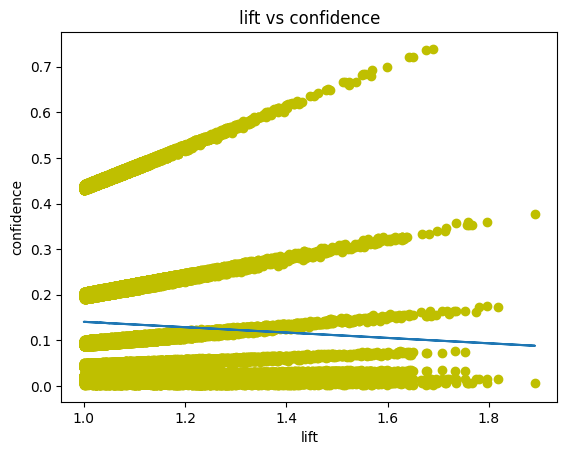

In [16]:
plot_metrics_relationship(fp_growth_rule_lift, col1='lift', col2='confidence')

In [17]:
apriori_matrix, apriori_exec_time = perform_rule_calculation(df, rule_type="apriori")
print("Apriori Execution took: {} seconds".format(apriori_exec_time))

Computed Apriori!
Apriori Execution took: 0.4907190799713135 seconds


In [18]:
apriori_rule_lift = compute_association_rule(apriori_matrix)

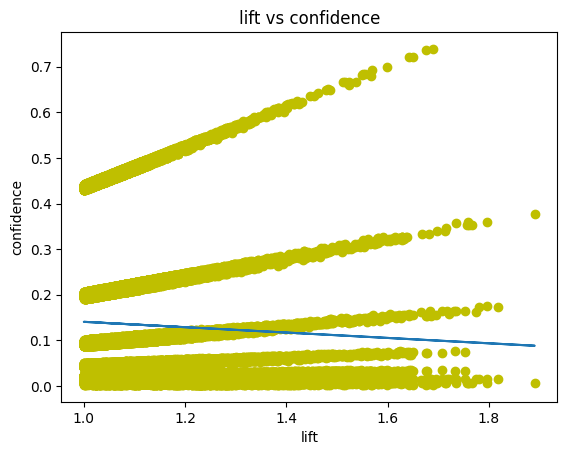

In [19]:
plot_metrics_relationship(apriori_rule_lift, col1='lift', col2='confidence')

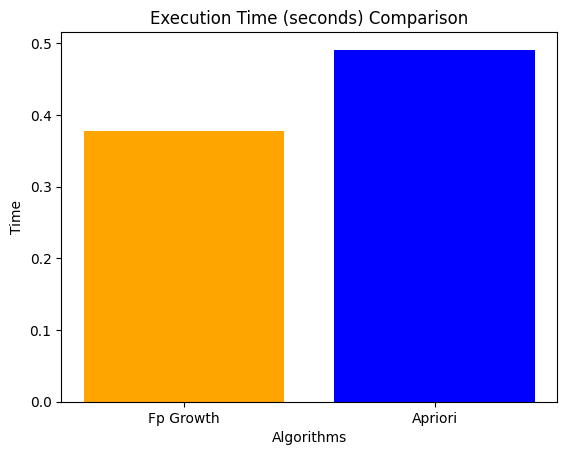

In [20]:
algo1 = ['Fp Growth', fp_growth_exec_time]
algo2 = ['Apriori', apriori_exec_time]
compare_time_exec(algo1, algo2)


Bu veri setinde benzer parametreler için örneğin support değeri 0.1 için iki algoritma da çıkan birliktelik kuralları aynı çıkmıştır.Fakat performans açısından  apriori algoritması fpgrowth algoritmasına göre daha yavaş çalışıyor.Ayrıca farklı farklı veri setleri üzerinde fpgrowth algoritmasının Aynı veri seti için daha net analiz yaptığı 
çalışmalar mevcuttur.Bizim çalışmamızda verdiğimiz confidence değerlerine göre iki algoritmanın farklı sonuçları mevcuttur.